In [495]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Predicting Titanic Survivors

In April 15, 1912, the Titanic sank after hitting an iceberg killing 1502 of 2224 passengers and crew. One of the reasons for the high loss of life was the shortage of lifeboats. Although there was some luck involved in who made it on the lifeboats, there was also a higher chance for women, children and upper-class passengers to have made it on the life boats.

The goal is to predict the outcome for passengers given information about their person and ticket on the Titanic. Data is given in the form of a test and training set. 

This data set is provided by Kaggle:
https://www.kaggle.com/c/titanic

## Data exploration

First let's load the training and test sets. They were provided in csv form. We will also make a combined dataframe for convenience while cleaning the data.

In [496]:
df = pd.read_csv('train.csv', index_col='PassengerId')
final= pd.read_csv('test.csv', index_col='PassengerId')
combined = pd.concat([df, final])

In [497]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Sex distribution
Let's start by looking at the sex distribution and overall survivor numbers. We see that there were significantly more males on board, and the a much higher proportion of females survived.

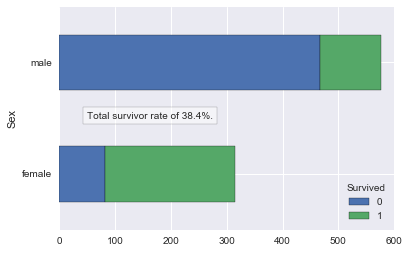

In [498]:
ax = df.groupby(['Sex','Survived']).size().unstack().plot(kind='barh', stacked=True)
surv_rate = sum(df['Survived']) / len(df)
ax.text(50, 0.5, 'Total survivor rate of %0.1f%%.' % (surv_rate * 100), 
          bbox=dict(facecolor='white', alpha=0.5))

## Age, class and sex distribution
We can then look at the age distribution by sex. The final age bin is opened to avoid having many small bins above an age of 65. We see a similar shaped distribution with more males in groups above age 15. We also see class 1 passengers with a flatter and older distribution.

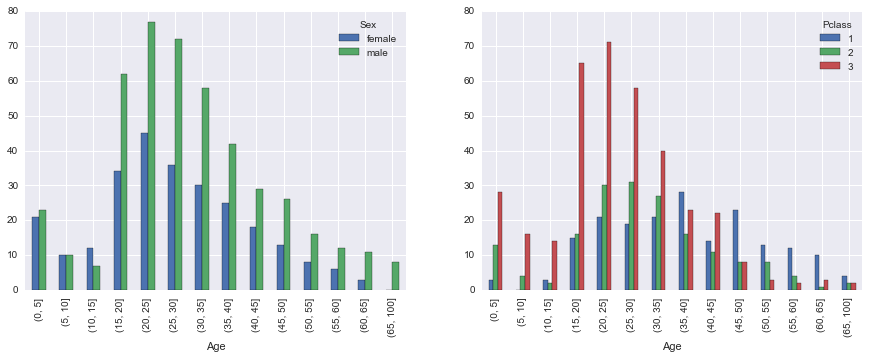

In [499]:
age_binned, age_bins = pd.cut(df['Age'], list(range(0, 66, 5)) + [100], retbins=True)
age_sex_grouped = df.groupby([age_binned, 'Sex'])
age_class_grouped = df.groupby([age_binned, 'Pclass'])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
age_sex_grouped.size().unstack().plot(kind='bar', ax=axs[0])
age_class_grouped.size().unstack().plot(kind='bar', ax=axs[1])

## Age and class survival rate
We can then look at the survival breakdown for the same age categories and class. In general, we see that younger and first class people were more likely to survive.

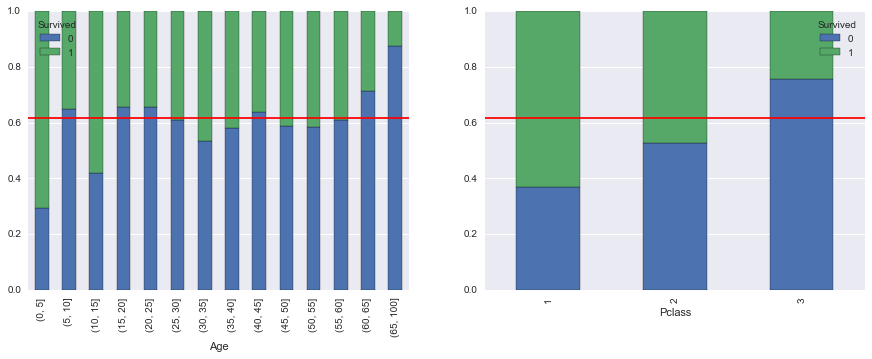

In [500]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
def normdf(df):
    return df.div(df.sum(axis=1), axis=0)

age_surv_grouped = df.groupby([age_binned, 'Survived'])
age_surv = age_surv_grouped.size().unstack()
normdf(age_surv).plot(kind='bar', stacked=True, ax=axs[0])

class_surv_grouped = df.groupby(['Pclass', 'Survived'])
class_surv = class_surv_grouped.size().unstack()
normdf(class_surv).plot(kind='bar', stacked=True, ax=axs[1])

for ax in axs: ax.plot(ax.get_xlim(), np.ones(2) * (1-surv_rate), 'r')

# Fare distribution
Fare prices form a sharply decaying distribution with some fares actually at zero dollars.

Free fares: 15


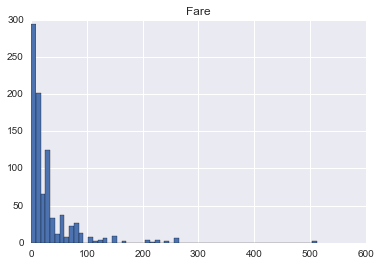

In [501]:
df.hist(column='Fare', bins=60)
print('Free fares: %s' % sum(df['Fare'] == 0.0))

## Low class male population
The sex distribution for 1st and 2nd class roughly follows the sex split, while in 3rd class there is a much larger male population.

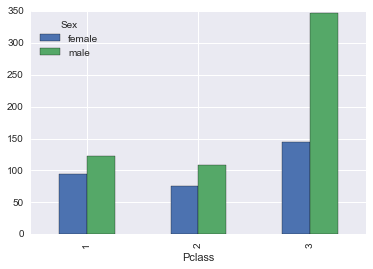

In [502]:
df.groupby(['Pclass', 'Sex']).size().unstack().plot.bar()

We will add a column for the total number of family members by combining SibSp and Parch. This well help to simplify our model and seems like a reasonable approximation that all family members would have equal pull on individuals. The previous male population also seems to stick out with zero family members on board.

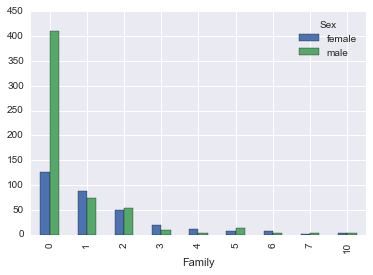

In [503]:
df['Family'] = df['SibSp'] + df['Parch']
final['Family'] = final['SibSp'] + final['Parch']

df.groupby(['Family', 'Sex']).size().unstack().plot(kind='bar')

We can confirm that this are the same males in 3rd class with no family members on board. This might have been people travelling overseas in search of work.

In [504]:
low_class_no_fam_males = (df['Sex'] == 'male') & (df['Family'] == 0)
print('%s low class males with no family and an average fare of $%0.2f.' % 
      (sum(low_class_no_fam_males), df[low_class_no_fam_males]['Fare'].mean()))
print('%0.1f%% of this population survived.' % 
      (100 * sum(df[low_class_no_fam_males]['Survived']/len(df[low_class_no_fam_males]))))

411 low class males with no family and an average fare of $16.71.
15.6% of this population survived.


# Filling missing data
To prepare our dataset for machine learning techniques, we need to deal with missing values. First, let's look at the number of null entries per column. We will also make a dummy variable for sex. This transforms it from 'male' and 'female' to 0 and 1.

In [505]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
final = pd.get_dummies(final, columns=['Sex'], drop_first=True)

In [506]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Family        0
Sex_male      0
dtype: int64

For now we are not using the Cabin or Embarked columns so we only need to deal with the Age column. As we saw above, the age distribution has a long tail and is significantly different by sex and class. We will use a group median to fill missing data with sex and class groups.

We can also see that the survival rate of the group with missing age values is ~10% lower then the total survivor rate. This group tends to be in 3rd class and male. In developing on this dataset, mishandling this population was significantly affecting my models accuracy. We will make a new column for the age filled data. It seems that it is not random which records did not include age information, this may be useful information.

In [507]:
df[df['Age'].isnull()][['Survived', 'Pclass', 'Sex_male']].describe()

,Survived,Pclass,Sex_male
count,177.000000,177.000000,177.000000
mean,0.293785,2.598870,0.700565
std,0.456787,0.763216,0.459310
min,0.000000,1.000000,0.000000
25%,0.000000,3.000000,0.000000
50%,0.000000,3.000000,1.000000
75%,1.000000,3.000000,1.000000
max,1.000000,3.000000,1.000000


In [508]:
class_sex_grouped = combined.groupby(['Pclass', 'Sex'])
class_sex_grouped['Age'].median()

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

We can see that it mostly added values at age 25, which is the 3rd class male population that most of our missing values fell in.

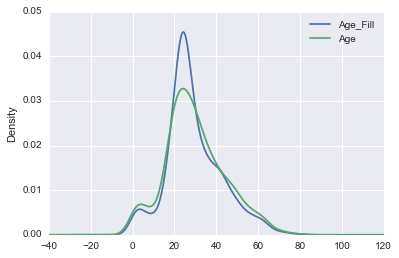

In [509]:
combined['Age_Fill'] = combined['Age']
combined['Age_Fill'] = class_sex_grouped['Age'].transform(lambda df: df.fillna(df.median()))
combined[['Age_Fill', 'Age']].plot(kind='kde')

df['Age_Fill'] = combined[~combined['Survived'].isnull()]['Age_Fill']
final['Age_Fill'] = combined[combined['Survived'].isnull()]['Age_Fill']

## Survival Visualizations
Let's now try and visualize survival trends in our data.

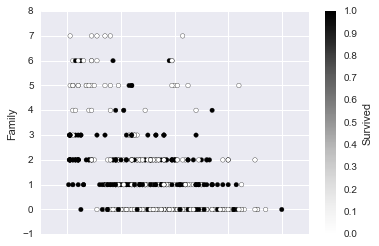

In [510]:
df.plot.scatter(x='Age', y='Family', c='Survived')

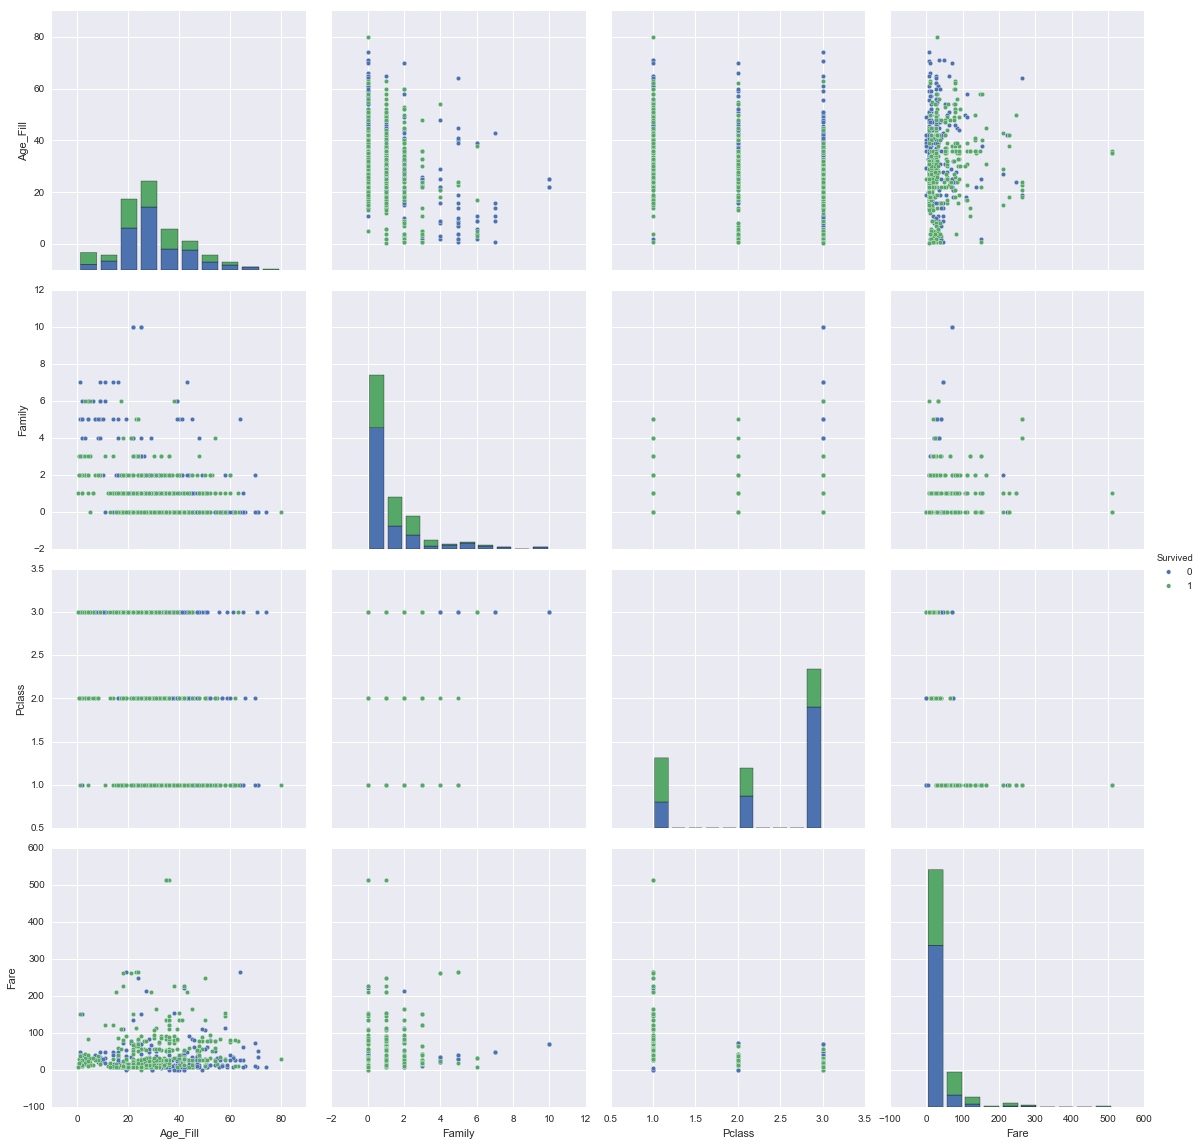

In [511]:
sns.pairplot(df, vars=['Age_Fill', 'Family', 'Pclass', 'Fare'], hue='Survived', size=4)

## Data Cleaning

We will remove the Name, Ticket, and Cabin fields to simplify our model and because they are difficult to parse. We will also add dummy variables to turn our categorical data into binary columns.

## Simple Models
Using the hypothesis that women, children, and upper class passengers were more likely to survive, we will build a category based model. We will break down the dataset into sex, class, and adult/children and calculate the survival rate within each group. If the survival rate is over 50% then our model will predict all passengers in that group to have survived. Similarily, if less then 50% survived it will predict that all passengers in that group perished. We will use this model as a benchmark when developing more sophisticated models.

In [512]:
def survivedPerc(df):
    return sum(df['Survived']) / len(df['Survived']) * 100
df.groupby(['Sex_male', 'Pclass', df['Age_Fill'] < 16]).apply(survivedPerc).unstack()

Age_Fill             False       True 
Sex_male Pclass                       
0.0      1       97.802198   66.666667
         2       90.909091  100.000000
         3       49.122807   53.333333
1.0      1       35.294118  100.000000
         2        8.080808  100.000000
         3       11.912226   32.142857

In [513]:
combined.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Age_Fill
PassengerId,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,22.0
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,38.0
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,26.0
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,35.0
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,35.0


In [522]:
def categoricalClassifier(df):
    num_surv = sum(df['Survived'])
    total = len(df['Survived'])
    correct = num_surv if (num_surv / total) > 0.5 else total - num_surv
    return Series({'Correct' : correct, 'Incorrect' : total - correct})
    
cat_clf = df.groupby(['Sex_male', 'Pclass', df['Age_Fill'] < 16]).apply(categoricalClassifier)
print('Accuracy: %0.1f' % (cat_clf['Correct'].sum() / cat_clf.stack().sum() * 100))

cat_clf = combined.groupby(['Sex', 'Pclass', df['Age_Fill'] < 16])
# def test(df):
#     df.fillna(round(df.mean()))

# combined['Survived_New'] = combined['Survived']
# combined['Survived_New'] = cat_clf['Survived'].transform(lambda df: df.fillna(4))
cat_clf.apply(lambda df: df['Survived'])
# combined[combined['PassengerId'] in final['PassengerId']]
# combined.ix[final.index]['Survived']
combined.tail()

# final['Survived'] = combined.ix[final.index]['Survived']
# final['Survived'] = combined.join(final, on='PassengerId', how='inner')['Survived']
# final['Survived']
# pd.concat([test['PassengerId'], Series(y_final, name='Survived')], axis=1).to_csv('Titanic_Predictions.csv', index=False)

Accuracy: 80.2


AttributeError: 'Series' object has no attribute 'fillnan'

## Model Training

First we split our data into training and test sets.

In [289]:
ml_cols = ['Pclass', 'Fare', 'Family', 'Sex_male', 'Age_Fill']
y = df['Survived']
X = df[ml_cols]
X_final = final[ml_cols]
df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family',
       'Sex_male', 'Age_Fill'], dtype=object)

In [290]:
X = pd.get_dummies(X, columns=['Pclass'], drop_first=True)
X_final = pd.get_dummies(X_final, columns=['Pclass'], drop_first=True)

In [291]:
X_final['Fare'].fillna(combined['Fare'].median(), inplace=True)

In [292]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

We then normalize all of the noncategorical columns

In [293]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# std_cols = ['Age_Fill', 'Fare', 'Pclass', 'Family']
std_cols = ['Age_Fill', 'Fare', 'Family']
sc.fit(X_train[std_cols])
X_train_std = X_train.copy()
X_test_std = X_test.copy()
X_final_std = X_final.copy()

X_train_std[std_cols] = sc.transform(X_train[std_cols])
X_test_std[std_cols] = sc.transform(X_test[std_cols])
X_final_std[std_cols] = sc.transform(X_final[std_cols])
X_train_std.head()

,Fare,Family,Sex_male,Age_Fill,Pclass_2,Pclass_3
301,-0.188014,0.754425,1.0,-0.337458,0.0,1.0
309,0.539690,-0.575156,0.0,0.029712,0.0,0.0
516,-0.463503,-0.575156,0.0,0.323448,1.0,0.0
120,0.897735,0.754425,1.0,-0.631194,1.0,0.0
570,-0.463503,-0.575156,1.0,2.379600,1.0,0.0


In [294]:
from sklearn.metrics import accuracy_score
def clfAccuracy(clf, X_train_std, X_test_std, y_train, y_test):
    clf.fit(X_train_std, y_train)
    y_train_pred = clf.predict(X_train_std)
    y_test_pred = clf.predict(X_test_std)
    print('Training Set Accuracy: %.2f\nTest Set Accuracy %.2f' % 
          (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))

In [295]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=10, random_state=0)
clfAccuracy(lr, X_train_std, X_test_std, y_train, y_test)

Training Set Accuracy: 0.81
Test Set Accuracy 0.80


In [296]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, p=2, metric='minkowski')
clfAccuracy(knn, X_train_std, X_test_std, y_train, y_test)

Training Set Accuracy: 0.89
Test Set Accuracy 0.79


In [297]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=20, random_state=1, n_jobs=2)
clfAccuracy(forest, X_train_std, X_test_std, y_train, y_test)

Training Set Accuracy: 0.87
Test Set Accuracy 0.79


In [298]:
y_final = forest.predict(X_final_std)
pd.concat([test['PassengerId'], Series(y_final, name='Survived')], axis=1).to_csv('Titanic_Predictions.csv', index=False)

ValueError: X has 2 features per sample; expecting 6

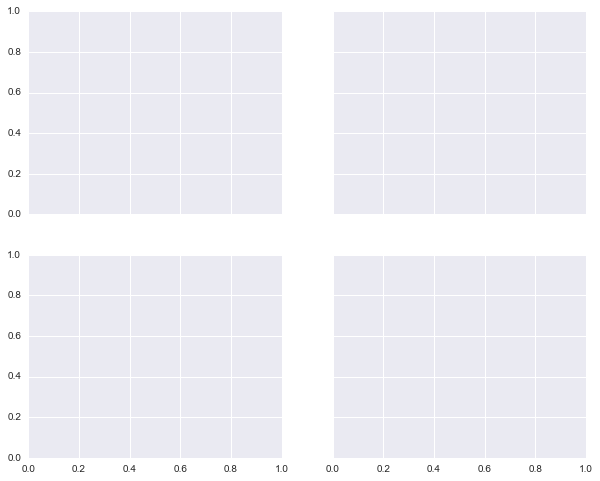

In [299]:
# Plotting decision regions
x_min, x_max = -5, 5
y_min, y_max = -1, 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for ax, clf, tt in zip(axarr.ravel(),
                        [lr, knn, forest, forest],
                        ['Lgistic regression', 'knn',
                         'forest', 'forest']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X_train_std['Age'], X_train_std['Fare'], c=y_train, alpha=0.8)
    ax.set_title(tt)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

plt.show()